In [1]:
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from obspy.signal.invsim import cosine_taper #used to smooth data at ends
from obspy.signal.filter import highpass #filter to remove low frequency noise from seismic data
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset#used to see when ratio is triggered

In [2]:
cat_file_path = r'C:\Users\akshi\Machine Learning Projects\Space Apps Challenge\data\lunar\training\catalogs\apollo12_catalog_GradeA_final.csv' #change this to the specific catalog file

cat = pd.read_csv(cat_file_path)
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


In [3]:
def plot_trace(trace, arrival_time=None, title="Seismic Data"):
    times = trace.times()
    data = trace.data

    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.plot(times, data)
    if arrival_time:
        ax.axvline(x=arrival_time, color='red', label='Arrival Time')
    ax.set_xlim([min(times), max(times)])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_title(title)
    ax.legend(loc='upper left')
    plt.show()
    
def plot_sta_lta_triggers(trace, cft, thr_on=4.0, thr_off=1.5):
    """
    Plots the STA/LTA characteristic function and marks trigger points.

    Parameters:
    trace (Trace object): Seismic trace data.
    cft (numpy.ndarray): Characteristic function from STA/LTA.
    thr_on (float): Threshold for detecting start of seismic activity.
    thr_off (float): Threshold for detecting end of seismic activity.
    """
    times = trace.times()
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))

    fig, ax = plt.subplots(1, 1, figsize=(12, 3))

    # Plot the characteristic function
    ax.plot(times, cft, label="STA/LTA")

    # Mark triggers
    for triggers in on_off:
        ax.axvline(x=times[triggers[0]], color='red', label='Trig. On')
        ax.axvline(x=times[triggers[1]], color='purple', label='Trig. Off')

    ax.set_xlim([min(times), max(times)])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('STA/LTA Ratio')
    ax.legend()
    plt.show()

In [4]:
def load_mseed(file_path):
    st = read(file_path)
    tr = st.traces[0].copy()
    return tr

def get_arrival(tr, time):
  tr_times = tr.times()
  tr_data = tr.data
  starttime = tr.stats.starttime.datetime
  return (time - starttime).total_seconds()

def apply_bandpass_filter(st, min_freq, max_freq):
    st_filt = st.copy()
    st_filt.filter('bandpass', freqmin=min_freq, freqmax=max_freq)
    return st_filt

def compute_sta_lta(trace, sta_len, lta_len):
    sampling_rate = trace.stats.sampling_rate
    cft = classic_sta_lta(trace.data, int(sta_len * sampling_rate), int(lta_len * sampling_rate))
    return cft

def detect_seismic_events(trace, sta_len, lta_len, thr_on=4.0, thr_off=1.5):
    cft = compute_sta_lta(trace, sta_len, lta_len)
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))
    return on_off
def detrend_trace(trace):
    return trace.detrend('linear')
def extract_sta_lta_features(trace, sta_len, lta_len):

    cft = compute_sta_lta(trace, sta_len, lta_len)


    max_sta_lta = np.max(cft)
    mean_sta_lta = np.mean(cft)
    var_sta_lta = np.var(cft)

    return max_sta_lta, mean_sta_lta, var_sta_lta

def extract_time_domain_features(trace):

    data = trace.data

    mean_amp = np.mean(data)
    max_amp = np.max(data)
    rms_amp = np.sqrt(np.mean(data**2))

    return mean_amp, max_amp, rms_amp

def extract_event_duration(trace, sta_len, lta_len, thr_on=4.0, thr_off=1.5):

    cft = compute_sta_lta(trace, sta_len, lta_len)
    on_off = trigger_onset(cft, thr_on, thr_off)

    if len(on_off) > 0:
        # Calculate the durations of each detected event
        event_durations = [(end - start) / trace.stats.sampling_rate for start, end in on_off]
        return np.mean(event_durations) if event_durations else 0
    return 0

In [33]:
for i in range(0, cat.shape[0]):
    row = cat.iloc[i]
    try:

        time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
        rel_time = row['time_rel(sec)']
        filename = row['filename']


        data_directory = 'C:\Users\akshi\Machine Learning Projects\Space Apps Challenge\data\lunar\training\data' 
        mseed_file = f'{data_directory}\{filename}.mseed'

        if load_mseed(mseed_file):
            tr = load_mseed(mseed_file)

            # Process the trace by getting the arrival and applying filters
            arrival = get_arrival(tr, time)
            tr_filt = apply_bandpass_filter(tr, 0.5, 1.0)

            # Plot the filtered traces (commented out for now)
            #plot_trace(tr_filt, arrival)

            #if needed
            tr_times_filt = tr_filt.times()
            tr_data_filt = tr_filt.data



            #EXTRACTING FEATURES





















    except FileNotFoundError:
        print(f"File not found: {mseed_file}. Skipping to the next file.")
    except Exception as e:
        print(f"An error occurred while processing {filename}: {e}")

In [6]:
import pandas as pd

# Initialize an empty list to store feature dictionaries for each file
features_list = []

for i in range(0, cat.shape[0]):
    row = cat.iloc[i]
    try:
        time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
        rel_time = row['time_rel(sec)']
        filename = row['filename']

        data_directory = r'C:\Users\akshi\Machine Learning Projects\Space Apps Challenge\data\lunar\training\data\S12_GradeA' 
        mseed_file = f'{data_directory}\{filename}.mseed'

        if load_mseed(mseed_file):
            tr = load_mseed(mseed_file)

            # Process the trace by getting the arrival and applying filters
            arrival = get_arrival(tr, time)
            tr_filt = apply_bandpass_filter(tr, 0.5, 1.0)

            # Get filtered data
            tr_times_filt = tr_filt.times()
            tr_data_filt = tr_filt.data

            # Detrend the trace
            tr_filt = detrend_trace(tr_filt)

            # Initialize a dictionary to hold features for this file
            features = {'filename': filename, 'arrival': arrival}

            # Extract STA/LTA features
            max_sta_lta, mean_sta_lta, var_sta_lta = extract_sta_lta_features(tr_filt, sta_len=120, lta_len=600)
            features['max_sta_lta'] = max_sta_lta
            features['mean_sta_lta'] = mean_sta_lta
            features['var_sta_lta'] = var_sta_lta

            # Extract time-domain features
            mean_amp, max_amp, rms_amp = extract_time_domain_features(tr_filt)
            features['mean_amp'] = mean_amp
            features['max_amp'] = max_amp
            features['rms_amp'] = rms_amp

            # Extract event duration
            event_duration = extract_event_duration(tr_filt, sta_len=1.0, lta_len=5.0, thr_on=4.0, thr_off=1.5)
            features['event_duration'] = event_duration

            # Append the features dictionary to the list
            features_list.append(features)

    except FileNotFoundError:
        print(f"File not found: {mseed_file}. Skipping to the next file.")
    except Exception as e:
        print(f"An error occurred while processing {filename}: {e}")

# Convert the list of feature dictionaries into a DataFrame
features_df = pd.DataFrame(features_list)

# Output the DataFrame (this line can be adjusted to save the DataFrame to a file)
features_df


File not found: C:\Users\akshi\Machine Learning Projects\Space Apps Challenge\data\lunar\training\data\S12_GradeA\xa.s12.00.mhz.1971-04-13HR00_evid00029.mseed. Skipping to the next file.


,filename,arrival,max_sta_lta,mean_sta_lta,var_sta_lta,mean_amp,max_amp,rms_amp,event_duration
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,73499.335,4.999992,1.000040,1.288825,-2.229023e-28,7.168520e-09,3.000852e-10,2.766931
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,12719.560,3.377245,1.000362,0.087481,-1.756677e-28,4.337924e-09,2.318099e-10,2.243568
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,73019.435,4.999997,1.022137,0.280708,2.067821e-28,5.446156e-09,2.508909e-10,2.454358
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,4439.804,4.075931,1.002945,0.184935,1.031420e-28,6.482011e-09,2.935849e-10,2.584866
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,52139.340,4.453052,0.999748,0.121439,-3.612704e-31,3.570016e-09,2.289006e-10,2.371272
...,...,...,...,...,...,...,...,...,...
70,xa.s12.00.mhz.1974-10-14HR00_evid00156,63779.004,4.988802,0.986454,0.892655,-5.768966e-29,5.891982e-09,2.325307e-10,3.038907
71,xa.s12.00.mhz.1975-04-12HR00_evid00191,65699.813,4.838773,1.005411,0.521538,2.782401e-28,5.288960e-08,1.837439e-09,2.935055
72,xa.s12.00.mhz.1975-05-04HR00_evid00192,36299.543,4.946264,0.992441,0.109598,3.750280e-28,1.034582e-07,3.437509e-09,1.670653
73,xa.s12.00.mhz.1975-06-24HR00_evid00196,57779.761,4.989918,1.012832,0.417255,9.583826e-29,6.624310e-09,1.961781e-10,2.673083


In [19]:
features_df.to_csv("Features.csv", index=False)

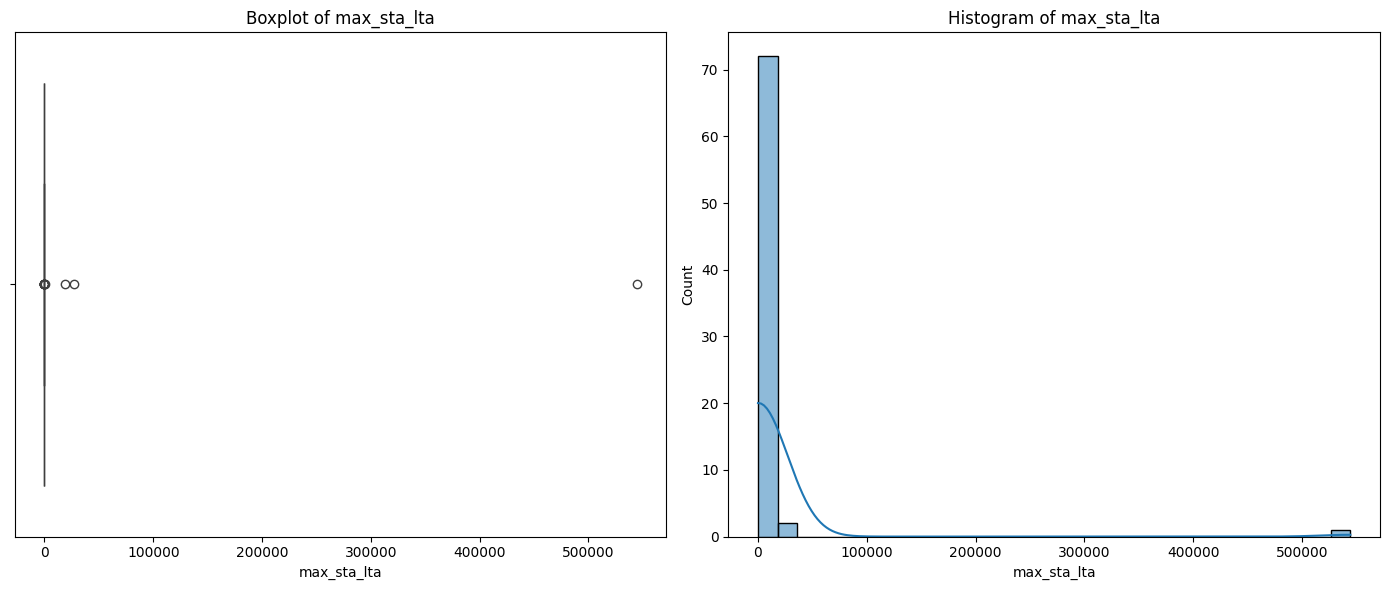


Outliers in max_sta_lta:
                                  filename    arrival    max_sta_lta  \
1   xa.s12.00.mhz.1970-03-25HR00_evid00003  12719.560       3.377245   
3   xa.s12.00.mhz.1970-04-25HR00_evid00006   4439.804       4.075931   
19  xa.s12.00.mhz.1971-03-25HR00_evid00028  55079.849       3.771215   
20  xa.s12.00.mhz.1971-04-17HR00_evid00030  25439.613  544599.564256   
23  xa.s12.00.mhz.1971-05-13HR00_evid00033  10799.817       3.822845   
40  xa.s12.00.mhz.1972-12-03HR00_evid00084   9479.448   19135.977843   
42  xa.s12.00.mhz.1973-01-31HR00_evid00091   2639.405      57.497908   
45  xa.s12.00.mhz.1973-03-24HR00_evid00097  69779.394       3.973783   
54  xa.s12.00.mhz.1973-07-28HR00_evid00120   3119.725   27448.885999   
61  xa.s12.00.mhz.1974-04-08HR00_evid00141  31199.466       4.038478   
64  xa.s12.00.mhz.1974-04-27HR00_evid00145  51479.354       3.777909   
65  xa.s12.00.mhz.1974-06-25HR00_evid00149   1379.476       3.531393   
69  xa.s12.00.mhz.1974-07-17HR00_evid0

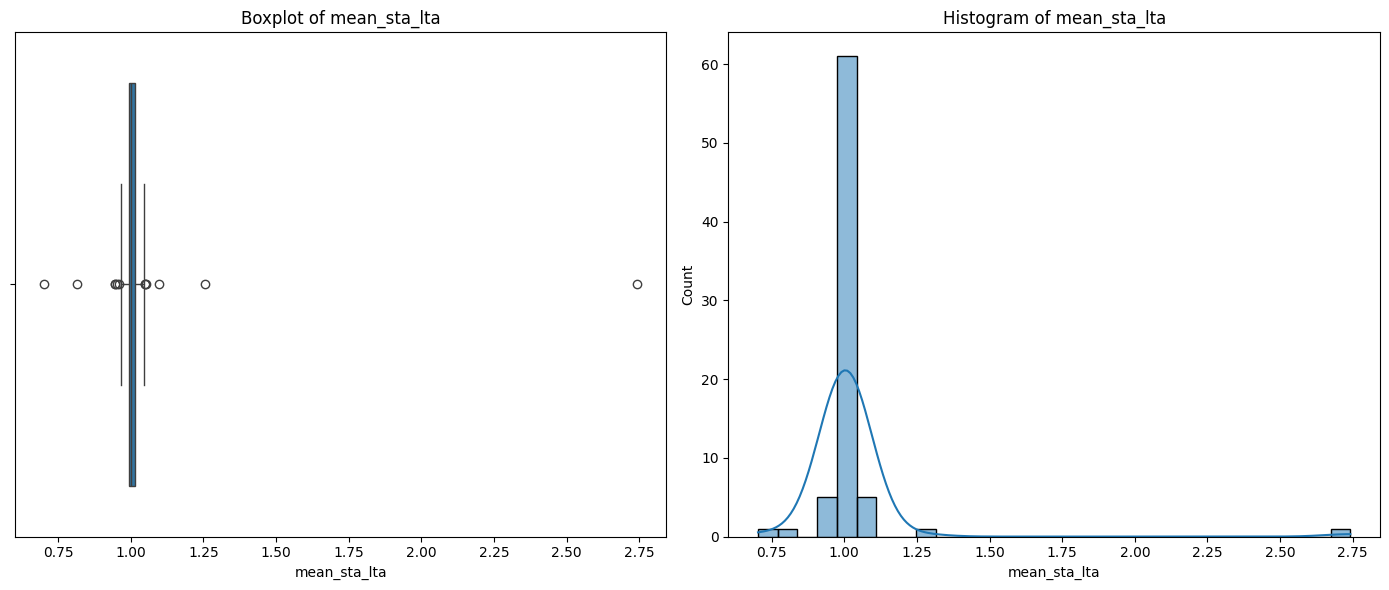


Outliers in mean_sta_lta:
                                  filename    arrival    max_sta_lta  \
11  xa.s12.00.mhz.1970-11-12HR00_evid00015  46199.300       4.999822   
20  xa.s12.00.mhz.1971-04-17HR00_evid00030  25439.613  544599.564256   
40  xa.s12.00.mhz.1972-12-03HR00_evid00084   9479.448   19135.977843   
41  xa.s12.00.mhz.1973-01-18HR00_evid00088  82859.338       4.890910   
42  xa.s12.00.mhz.1973-01-31HR00_evid00091   2639.405      57.497908   
43  xa.s12.00.mhz.1973-03-01HR00_evid00093  26099.655       4.651594   
47  xa.s12.00.mhz.1973-06-05HR00_evid00107   9479.700       4.975734   
48  xa.s12.00.mhz.1973-06-05HR00_evid00108  40199.700       4.975734   
54  xa.s12.00.mhz.1973-07-28HR00_evid00120   3119.725   27448.885999   
58  xa.s12.00.mhz.1974-02-07HR00_evid00137  22859.646       4.999996   
60  xa.s12.00.mhz.1974-03-25HR00_evid00140  61079.402       4.999998   
62  xa.s12.00.mhz.1974-04-19HR00_evid00142  66839.432       4.989293   

    mean_sta_lta    var_sta_lta     

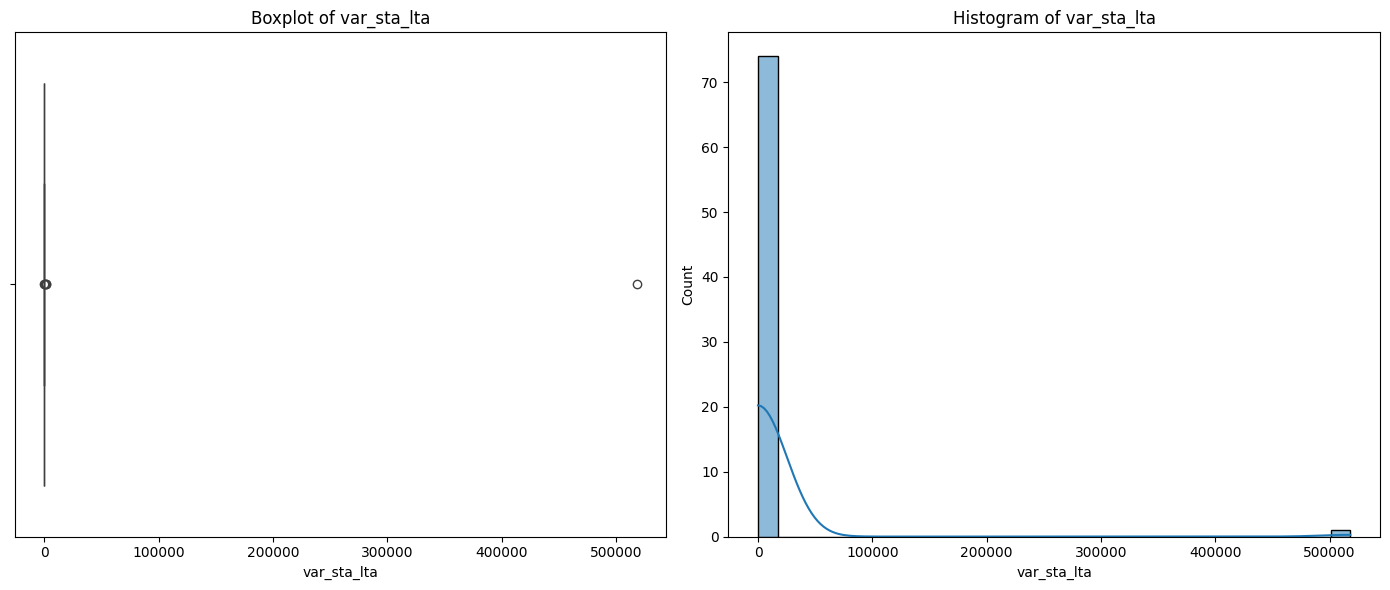


Outliers in var_sta_lta:
                                  filename    arrival    max_sta_lta  \
20  xa.s12.00.mhz.1971-04-17HR00_evid00030  25439.613  544599.564256   
33  xa.s12.00.mhz.1972-05-11HR00_evid00055  48899.424       4.999847   
40  xa.s12.00.mhz.1972-12-03HR00_evid00084   9479.448   19135.977843   
42  xa.s12.00.mhz.1973-01-31HR00_evid00091   2639.405      57.497908   
54  xa.s12.00.mhz.1973-07-28HR00_evid00120   3119.725   27448.885999   

    mean_sta_lta    var_sta_lta      mean_amp       max_amp       rms_amp  \
20      1.096358  518225.766870  4.078693e-28  2.196169e-08  5.976802e-10   
33      0.975877       2.077293 -1.688114e-28  7.996784e-09  3.480435e-10   
40      1.257355    1228.539121  9.948692e-29  2.930554e-09  2.031248e-10   
42      2.741718      66.998856 -1.103035e-29  1.979749e-09  1.262520e-10   
54      0.703270    1405.317516  2.227181e-28  1.081183e-08  3.927679e-10   

    event_duration  
20        2.379892  
33        2.747688  
40        3.289

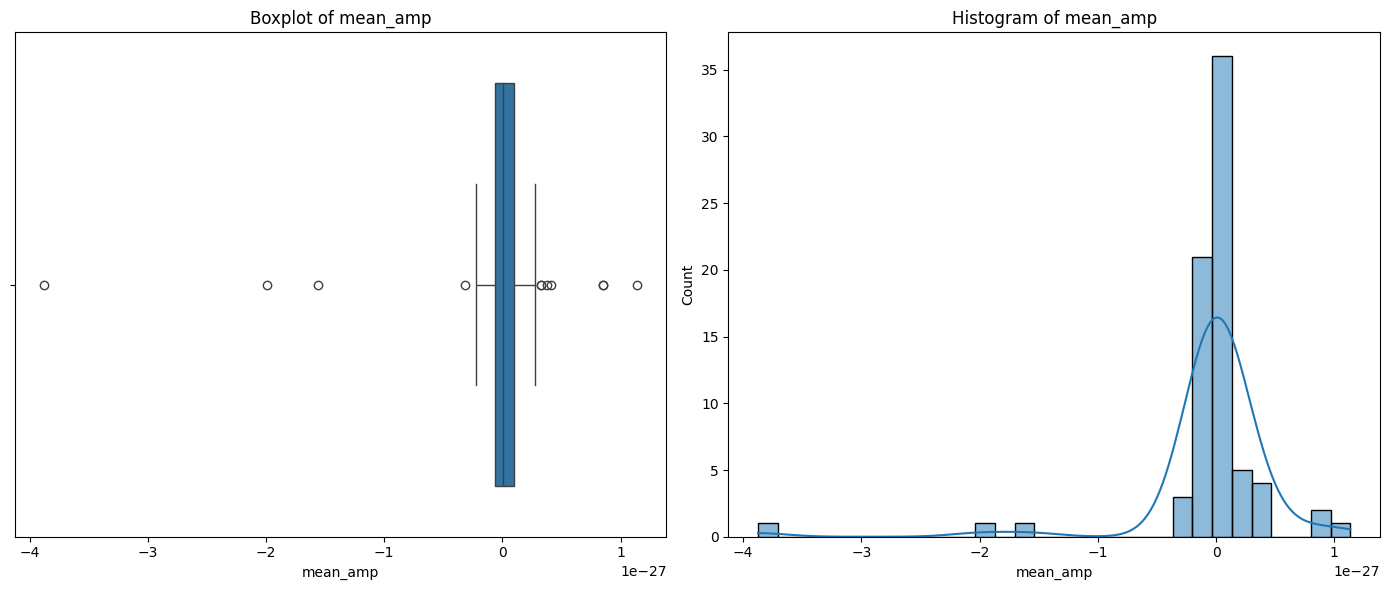


Outliers in mean_amp:
                                  filename    arrival    max_sta_lta  \
7   xa.s12.00.mhz.1970-07-20HR00_evid00010  18359.513       4.452394   
8   xa.s12.00.mhz.1970-07-20HR00_evid00011  42239.513       4.452394   
20  xa.s12.00.mhz.1971-04-17HR00_evid00030  25439.613  544599.564256   
24  xa.s12.00.mhz.1971-05-23HR00_evid00034  80399.498       4.998303   
25  xa.s12.00.mhz.1971-06-12HR00_evid00035  39059.471       4.991714   
28  xa.s12.00.mhz.1971-10-20HR00_evid00044  65279.575       4.999999   
35  xa.s12.00.mhz.1972-07-17HR00_evid00067  28199.816       4.725934   
36  xa.s12.00.mhz.1972-07-17HR00_evid00068  78959.816       4.725934   
38  xa.s12.00.mhz.1972-07-31HR00_evid00071  65279.378       4.725781   
44  xa.s12.00.mhz.1973-03-13HR00_evid00094  28859.528       4.865085   
72  xa.s12.00.mhz.1975-05-04HR00_evid00192  36299.543       4.946264   

    mean_sta_lta    var_sta_lta      mean_amp       max_amp       rms_amp  \
7       1.006218       0.281586  3.

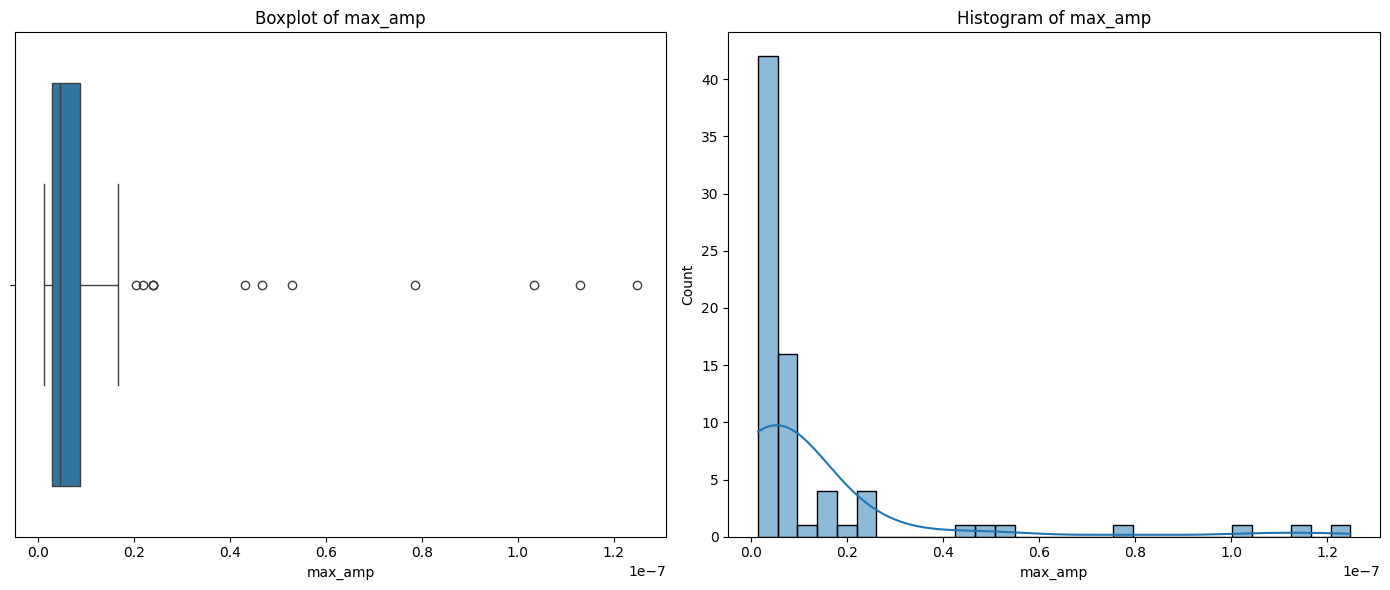


Outliers in max_amp:
                                  filename    arrival    max_sta_lta  \
6   xa.s12.00.mhz.1970-06-26HR00_evid00009  72059.884       4.826850   
20  xa.s12.00.mhz.1971-04-17HR00_evid00030  25439.613  544599.564256   
24  xa.s12.00.mhz.1971-05-23HR00_evid00034  80399.498       4.998303   
25  xa.s12.00.mhz.1971-06-12HR00_evid00035  39059.471       4.991714   
27  xa.s12.00.mhz.1971-10-18HR00_evid00043  11939.583       4.969791   
28  xa.s12.00.mhz.1971-10-20HR00_evid00044  65279.575       4.999999   
35  xa.s12.00.mhz.1972-07-17HR00_evid00067  28199.816       4.725934   
36  xa.s12.00.mhz.1972-07-17HR00_evid00068  78959.816       4.725934   
44  xa.s12.00.mhz.1973-03-13HR00_evid00094  28859.528       4.865085   
59  xa.s12.00.mhz.1974-02-12HR00_evid00138  80999.600       4.971550   
71  xa.s12.00.mhz.1975-04-12HR00_evid00191  65699.813       4.838773   
72  xa.s12.00.mhz.1975-05-04HR00_evid00192  36299.543       4.946264   

    mean_sta_lta    var_sta_lta      mean

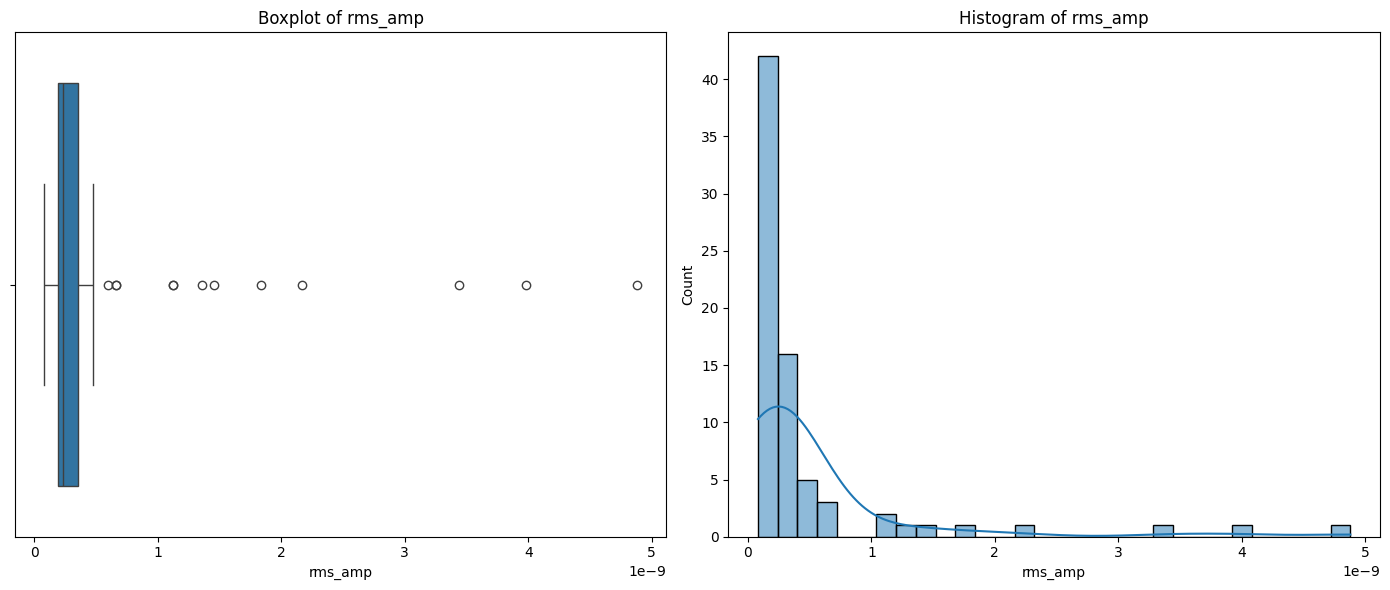


Outliers in rms_amp:
                                  filename    arrival    max_sta_lta  \
6   xa.s12.00.mhz.1970-06-26HR00_evid00009  72059.884       4.826850   
7   xa.s12.00.mhz.1970-07-20HR00_evid00010  18359.513       4.452394   
8   xa.s12.00.mhz.1970-07-20HR00_evid00011  42239.513       4.452394   
20  xa.s12.00.mhz.1971-04-17HR00_evid00030  25439.613  544599.564256   
24  xa.s12.00.mhz.1971-05-23HR00_evid00034  80399.498       4.998303   
25  xa.s12.00.mhz.1971-06-12HR00_evid00035  39059.471       4.991714   
28  xa.s12.00.mhz.1971-10-20HR00_evid00044  65279.575       4.999999   
35  xa.s12.00.mhz.1972-07-17HR00_evid00067  28199.816       4.725934   
36  xa.s12.00.mhz.1972-07-17HR00_evid00068  78959.816       4.725934   
44  xa.s12.00.mhz.1973-03-13HR00_evid00094  28859.528       4.865085   
71  xa.s12.00.mhz.1975-04-12HR00_evid00191  65699.813       4.838773   
72  xa.s12.00.mhz.1975-05-04HR00_evid00192  36299.543       4.946264   

    mean_sta_lta    var_sta_lta      mean

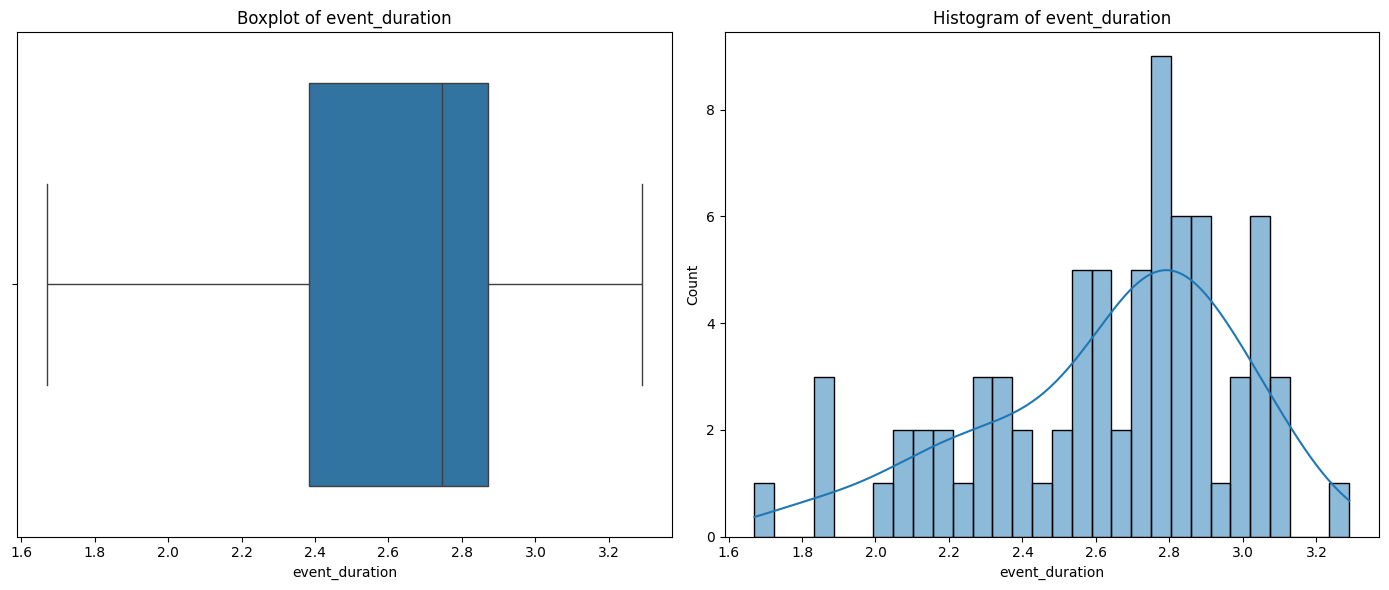


No outliers found in event_duration.


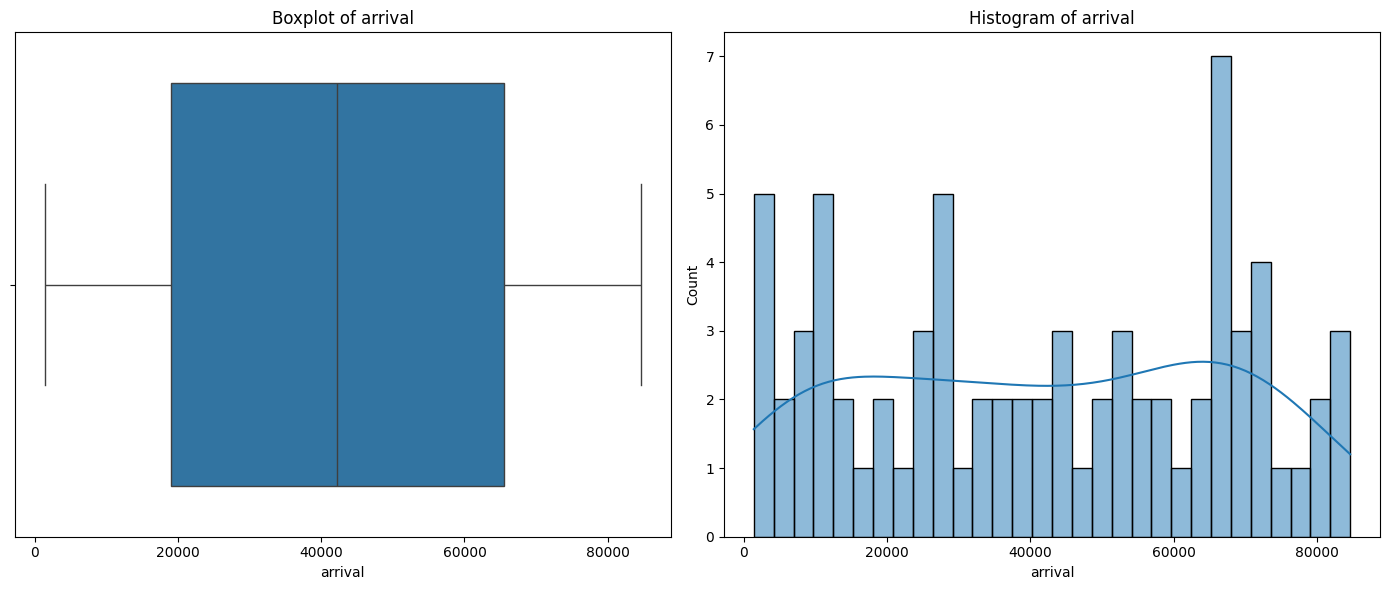


No outliers found in arrival.


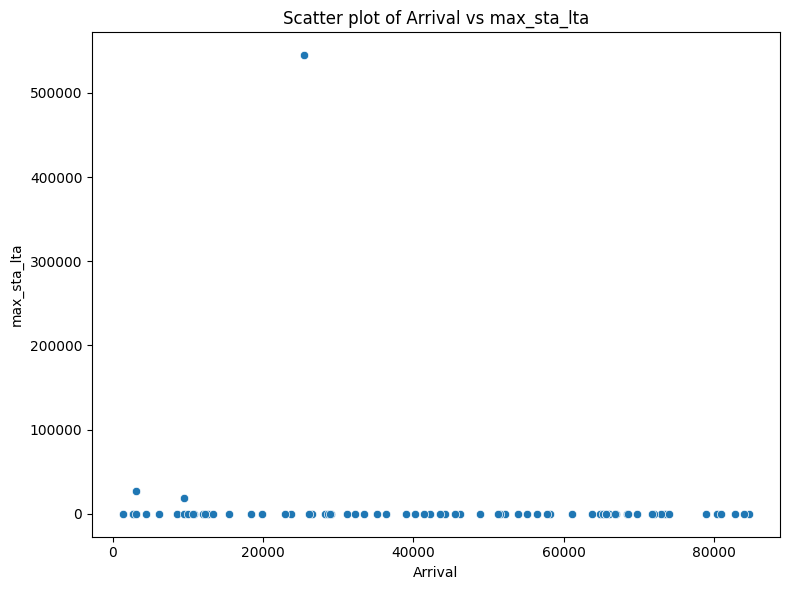

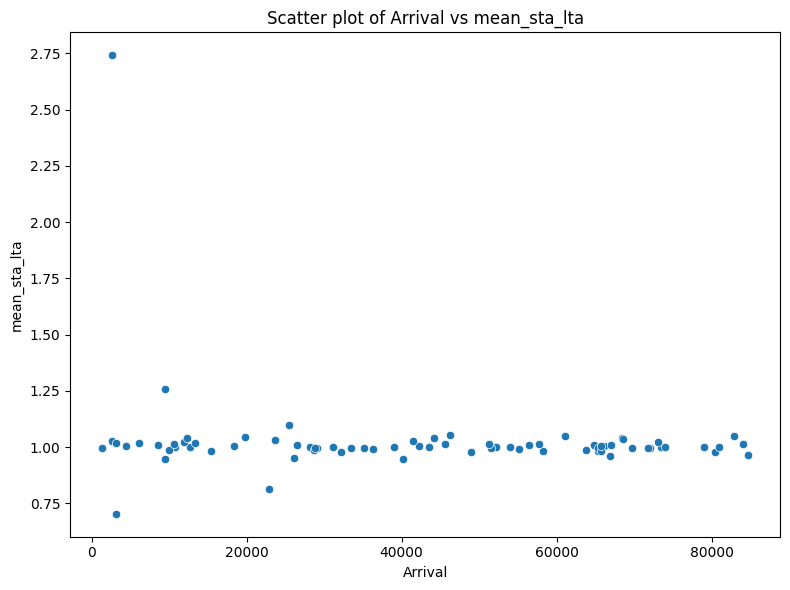

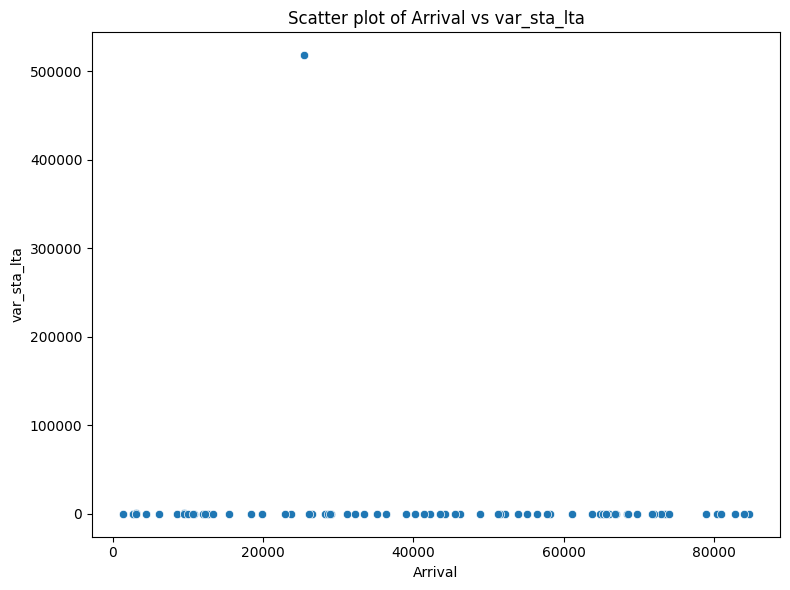

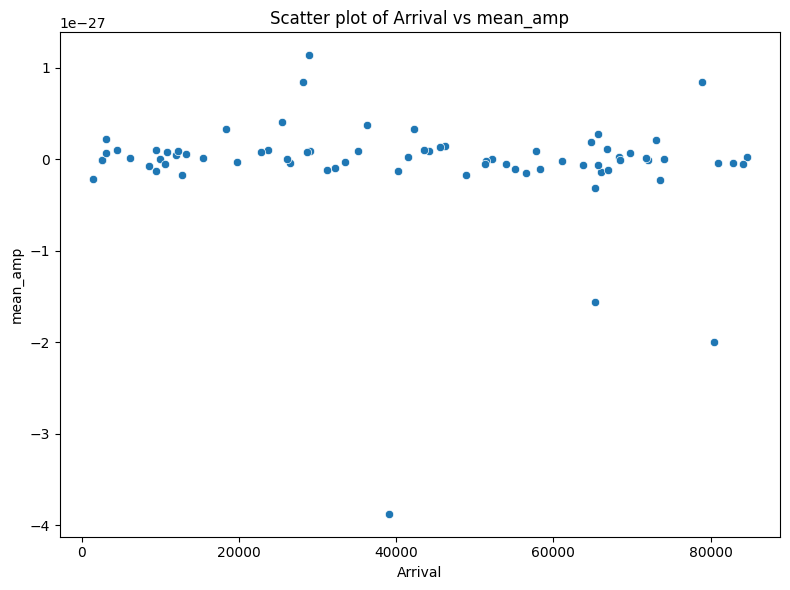

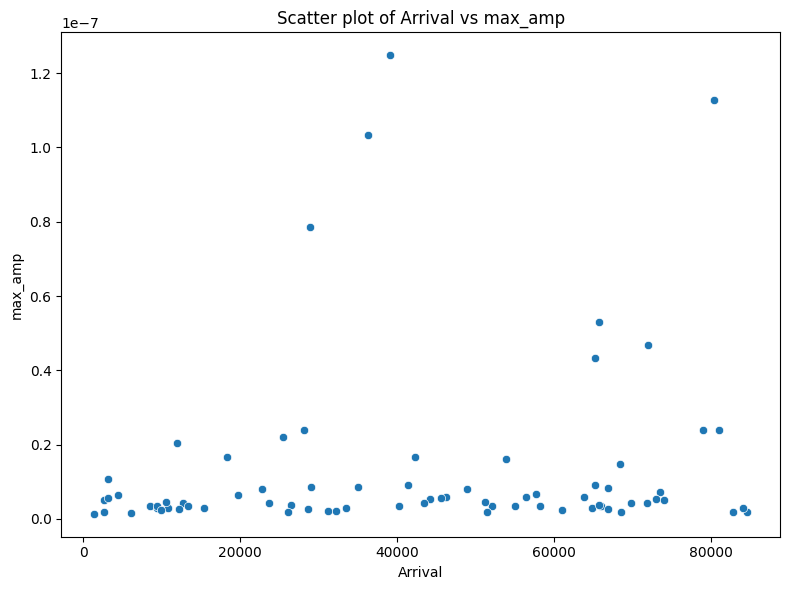

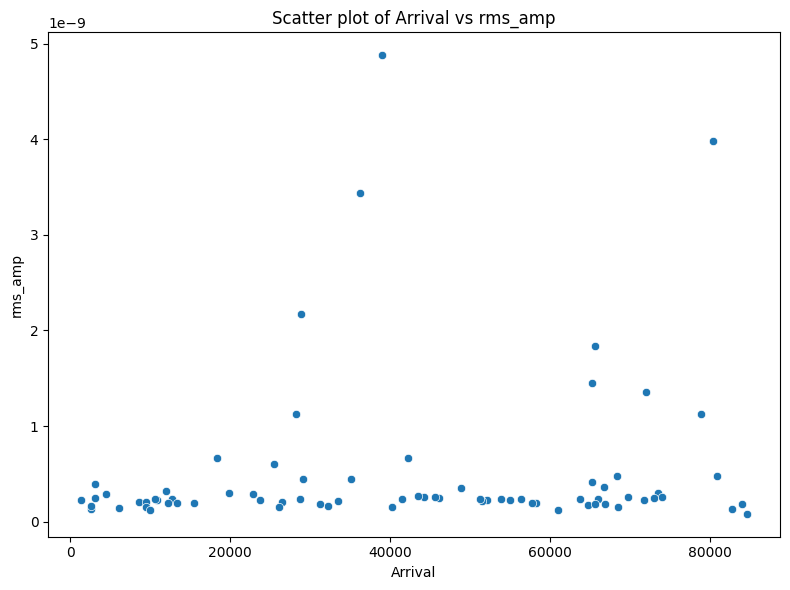

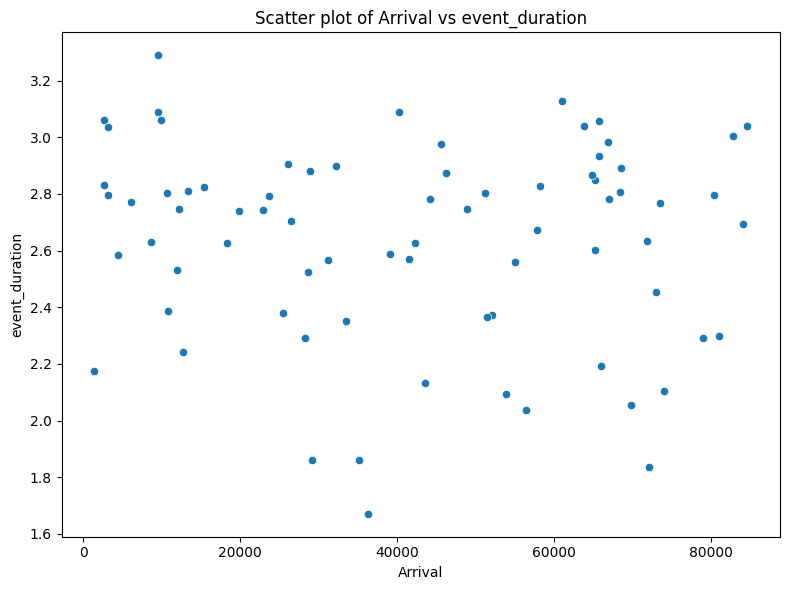

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of columns to plot (excluding the filename and arrival columns, which are not part of the scatter comparison)
feature_columns = ['max_sta_lta', 'mean_sta_lta', 'var_sta_lta', 'mean_amp', 'max_amp', 'rms_amp', 'event_duration']

# Create a directory to save the plots if necessary
import os
output_dir = 'plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Function to detect and return outliers using IQR
def find_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)]

# Plotting for each feature column
for column in feature_columns + ['arrival']:  # Including 'arrival' for boxplot and histogram
    # Create a new figure for the plots
    plt.figure(figsize=(14, 6))
    
    # Horizontal boxplot to show outliers
    plt.subplot(1, 2, 1)
    sns.boxplot(data=features_df[column], orient='h')  # Horizontal boxplot
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    
    # Histogram to show distribution
    plt.subplot(1, 2, 2)
    sns.histplot(features_df[column], kde=True, bins=30)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{column}_box_hist.png')  # Save the figure
    plt.show()  # Show the plot

    # Find and print outliers
    outliers = find_outliers(features_df[column])
    if not outliers.empty:
        print(f"\nOutliers in {column}:")
        print(features_df.loc[outliers.index])  # Print the rows where outliers occur
    else:
        print(f"\nNo outliers found in {column}.")

# Scatter plot: Arrival vs other columns
for column in feature_columns:
    plt.figure(figsize=(8, 6))
    
    # Scatter plot of arrival vs the current column
    sns.scatterplot(x='arrival', y=column, data=features_df)
    
    # Set plot title and labels
    plt.title(f'Scatter plot of Arrival vs {column}')
    plt.xlabel('Arrival')
    plt.ylabel(column)
    
    # Save the scatter plot
    plt.tight_layout()
    plt.savefig(f'{output_dir}/scatter_arrival_vs_{column}.png')  # Save the scatter plot
    plt.show()  # Display the plot


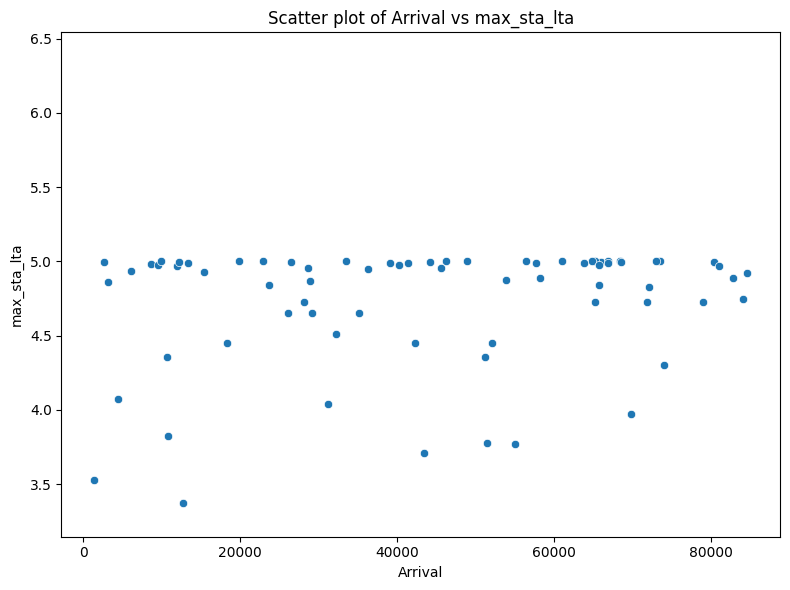

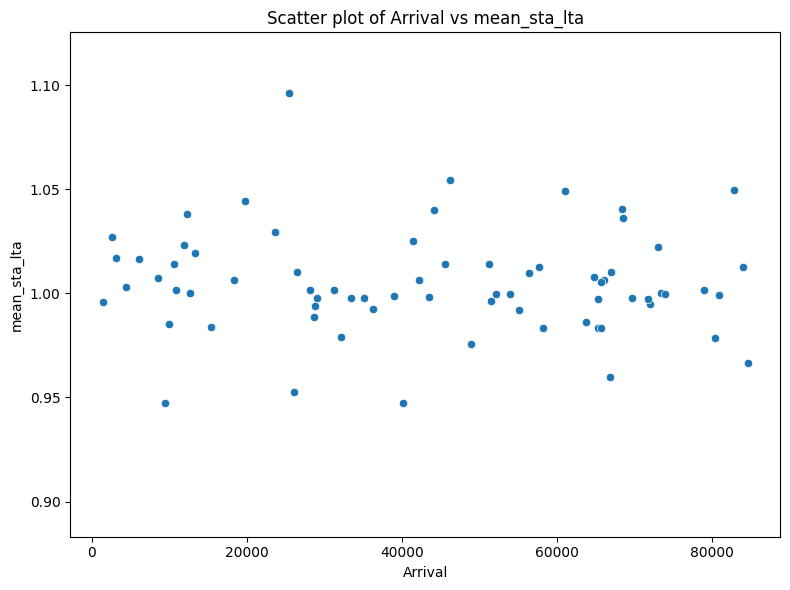

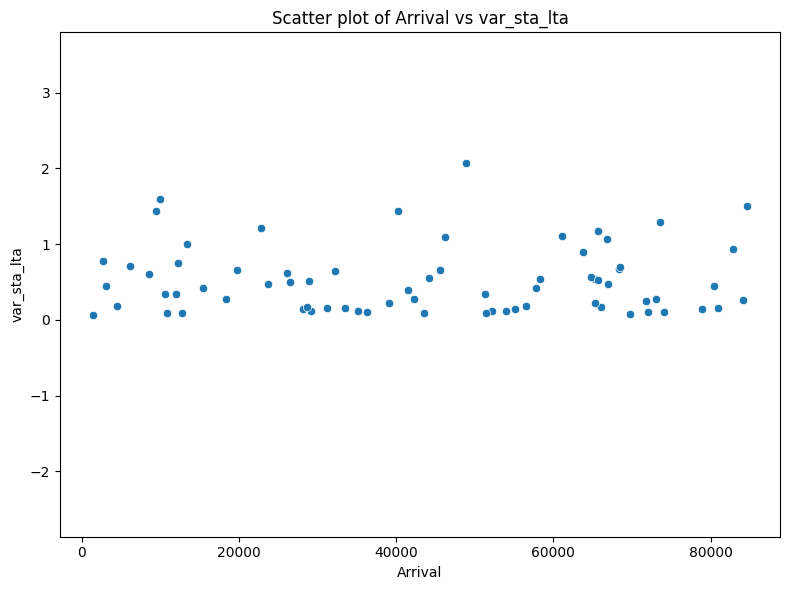

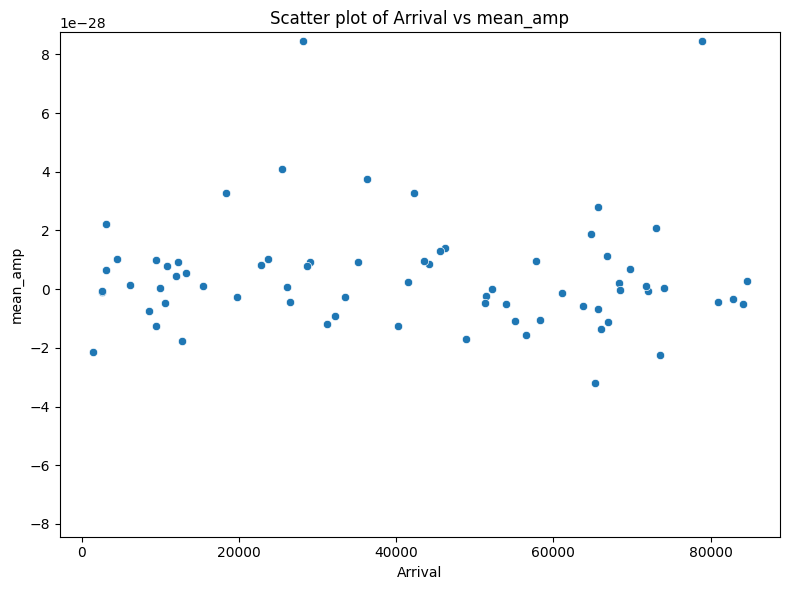

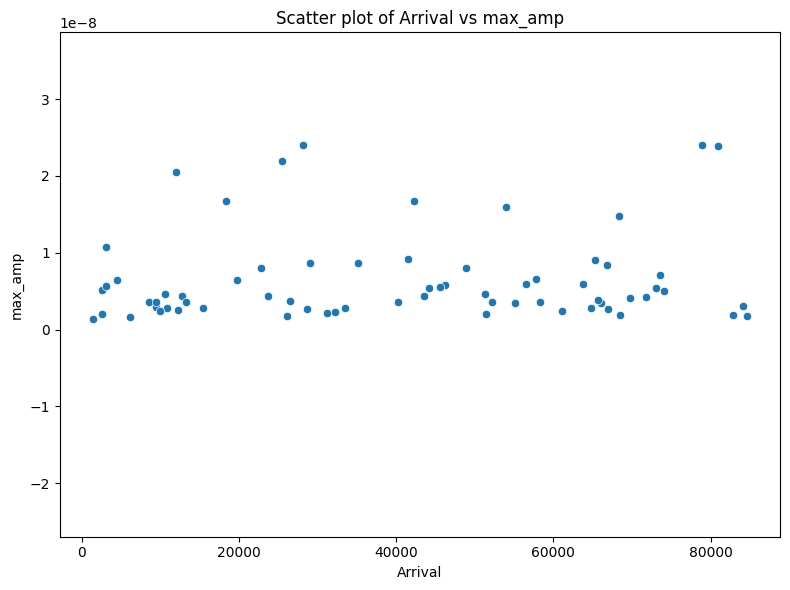

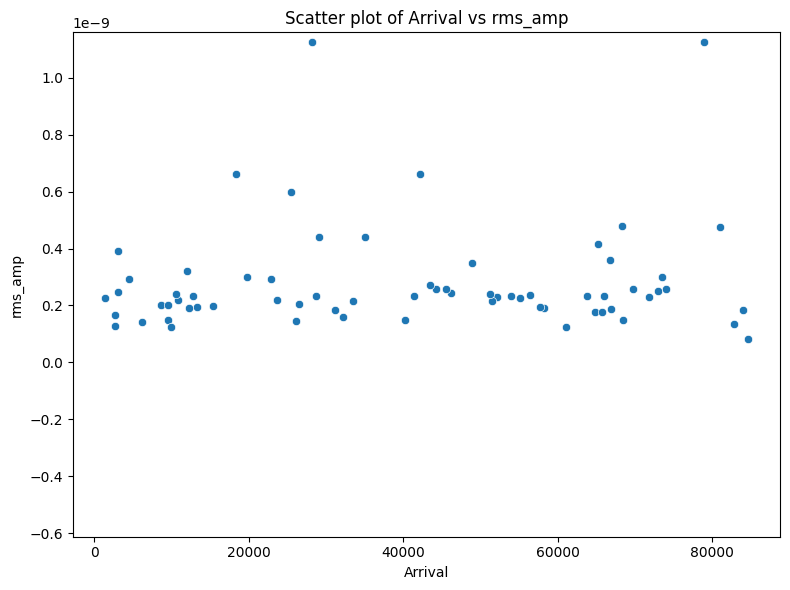

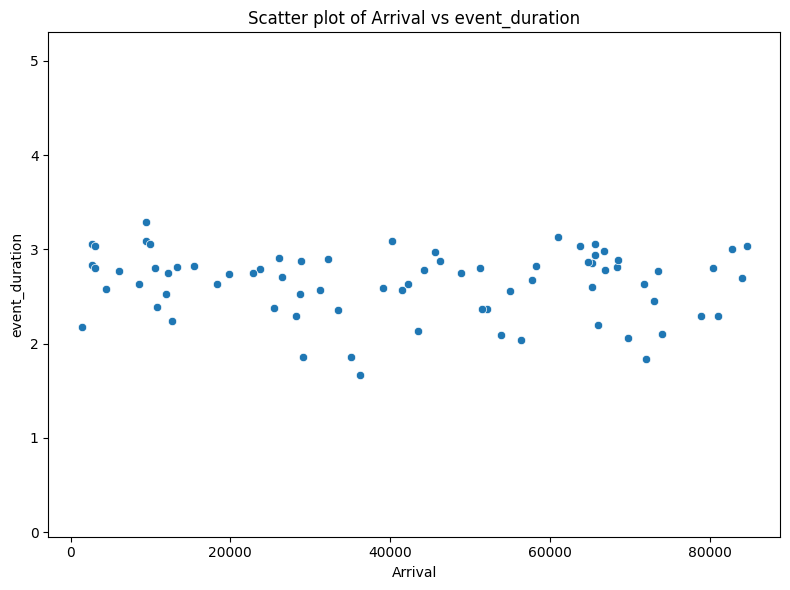

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of columns to plot (excluding the filename and arrival columns)
feature_columns = ['max_sta_lta', 'mean_sta_lta', 'var_sta_lta', 'mean_amp', 'max_amp', 'rms_amp', 'event_duration']

# Create a directory to save the plots if necessary
import os
output_dir = 'plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Function to detect and return outliers using IQR
def find_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)]

# Function to calculate 5*IQR limits for y-axis
def get_5iqr_limits(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 5 * IQR
    upper_bound = Q3 + 5 * IQR
    return lower_bound, upper_bound

# Scatter plot: Arrival vs other columns with 5*IQR limits on y-axis
for column in feature_columns:
    plt.figure(figsize=(8, 6))
    
    # Scatter plot of arrival vs the current column
    sns.scatterplot(x='arrival', y=column, data=features_df)
    
    # Set plot title and labels
    plt.title(f'Scatter plot of Arrival vs {column}')
    plt.xlabel('Arrival')
    plt.ylabel(column)
    
    # Calculate y-axis limits based on 5*IQR
    y_lower, y_upper = get_5iqr_limits(features_df[column])
    plt.ylim(y_lower, y_upper)
    
    # Save the scatter plot
    plt.tight_layout()
    plt.savefig(f'{output_dir}/scatter_arrival_vs_{column}.png')  # Save the scatter plot
    plt.show()  # Display the plot
